# Introduction

See PyTorch's [Data Loading and Processing Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import os
import re
import dill as pickle
import itertools
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 4)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

from utils import *

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Simulated prices

## Data Generation

In [7]:
def sim_path(N=500, sigma=0.35, S0=1, dt=1/250,
             mu=[0.05, 0.05], P=np.array([[0.95, 0.05], [0.1, 0.9]]),
             wdt_hl=2):
    
    # State simulation
    state = np.random.randint(0, 2)
    states = [state]
    for t in range(N - 1):
        state = int(np.random.multinomial(1, P[state, :]).argmax())
        states.append(state)
    
    # Price simulation
    drift = (np.array([mu[s] for s in states[1:]]) - 0.5 * sigma**2) * dt
    wiener = np.random.randn(N - 1) * sigma * np.sqrt(dt)

    S = S0 * np.concatenate((np.ones(1), np.exp(np.cumsum(drift + wiener))))
    
    res_df = DataFrame(data=dict(Close=S))
    res_df = res_df.assign(Date = pd.date_range(start=datetime(2018, 1, 1),
                                                periods=N, freq='D')).set_index('Date')
    
    res_df = res_df.assign(Open = res_df.Close.shift(-1).fillna(method='ffill') * \
                                    np.exp((np.random.rand(N) - 0.5) * sigma * np.sqrt(dt)))
    
    res_df = res_df.assign(High = res_df[['Open', 'Close']].max(axis=1) * \
                                np.exp(np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)),
                           Low = res_df[['Open', 'Close']].min(axis=1) * \
                                np.exp(- np.random.rand(N) * wdt_hl * sigma * np.sqrt(dt)))

    return res_df[['Open', 'High', 'Low', 'Close']]

In [8]:
price_df = add_changes(clean_trends(find_trends(sim_path())))
price_df

,Open,High,Low,Close,Smoothed,Trend,n_Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End,Ch,Ch2,Ch3,Ch4
Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.992547,1.037594,0.982294,1.000000,1.079005,1.0,1.0,0.136992,0.069311,0.135766,0.02874,1.477384,2.538517,18.530451,2018-01-01,2018-02-26,0.000000,0.000000,0.000000e+00,0.000000e+00
2018-01-02,0.950185,1.044251,0.935144,1.002236,1.079682,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018-02-26,0.002234,0.000005,1.114827e-08,2.490445e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-14,1.098483,1.164913,1.090467,1.119564,1.090183,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-29,2019-05-15,0.002924,0.000009,2.499848e-08,7.309451e-11
2019-05-15,1.090829,1.145612,1.055031,1.101842,1.090199,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-29,2019-05-15,-0.015956,0.000255,-4.062566e-06,6.482371e-08


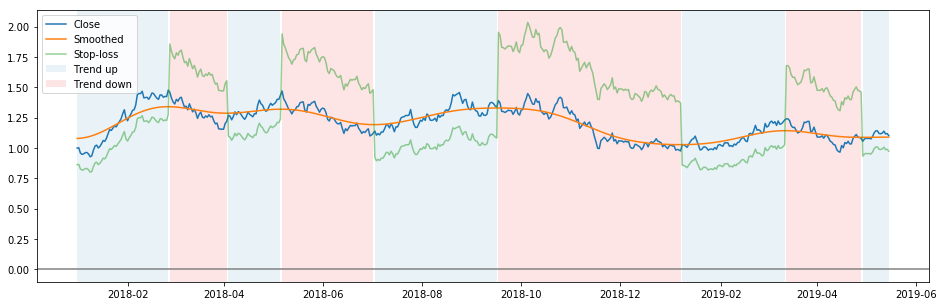

In [9]:
plot_trends(price_df)

## Dataset Class

In [31]:
class SimulatedPricesDataset(Dataset):
    """Simulated Prices Dataset"""
    def __init__(self, N, sim_fun, 
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR'],
                 sd=20, min_icagr=None,
                 Ch=None, tech_windows=None,
                 transform=None):
        """
        Args:
            N (int): number of prices to simulate.
            sim_fun: function that returns a simulated price DataFrame: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.N = N
        self.sim_fun = sim_fun
        self.targets = targets
        self.features = features
        self.sd = sd
        self.min_icagr = min_icagr
        self.Ch = Ch
        self.tech_windows = tech_windows
        self.transform = transform
        
    
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        assert idx < self.N
        
        sim_df = self.sim_fun()
        
        targets_df = find_trends(sim_df, sd=self.sd)
        if self.min_icagr:
            targets_df = clean_trends(targets_df, min_icagr=self.min_icagr)
        if self.targets:
            targets_df = targets_df[self.targets]
            
        if self.Ch:
            sim_df = add_changes(sim_df)
        if self.tech_windows:
            sim_df = add_technical(sim_df, windows=self.tech_windows)
        if self.features:
            sim_df = sim_df[self.features]
            
        sample = {'targets': targets_df, 'features': sim_df}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [32]:
sim_dataset = SimulatedPricesDataset(4, lambda: sim_path(N=2500),
#                                      targets=['Trend'],
                                     min_icagr=0.3, Ch=True, tech_windows=[30, 100])

In [34]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)

(2500, 20) (2500, 3)


In [33]:
sim_j['features']

,Open,High,Low,Close,Ch,Ch2,Ch3,Ch4,SMA_30,SMA_100,sigma2_SMA_30,sigma2_SMA_100,skew_SMA_30,skew_SMA_100,kurt_SMA_30,kurt_SMA_100,Support_30,Support_100,Resistance_30,Resistance_100
Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.014024,1.037053,0.975907,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000,0.000000,1.414214,1.414214,-1.000000,-1.000000,0.975907,0.975907,1.037053,1.037053
2018-01-02,0.974078,1.014260,0.970175,1.012319,0.012244,0.000150,1.835534e-06,2.247414e-08,1.006160,1.006160,0.000075,0.000075,1.414214,1.414214,-1.000000,-1.000000,0.970175,0.970175,1.037053,1.037053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03,1.201218,1.226048,1.152647,1.200794,-0.017652,0.000312,-5.500159e-06,9.708832e-08,1.294761,1.267886,0.000602,0.000577,-1.009300,-0.181077,0.231154,-0.064651,1.107652,1.025958,1.475534,1.551909
2024-11-04,1.198726,1.226222,1.187521,1.190531,-0.008583,0.000074,-6.323504e-07,5.427632e-09,1.287780,1.269166,0.000598,0.000551,-1.014762,-0.299765,0.271719,-0.014740,1.107652,1.027764,1.475534,1.551909


In [35]:
sim_j['targets']

,Trend,Max_Drawdown,ATR
Date,,,
2018-01-01,1.0,0.131957,0.070859
2018-01-02,1.0,NaN,NaN
...,...,...,...
2024-11-03,0.0,NaN,NaN
2024-11-04,0.0,NaN,NaN


## Transforms

In [36]:
class ToArray(object):
    def __call__(self, sample):
        targets, features = sample['targets'], sample['features']
        return {'targets': targets.values, 'features': features.values}
        

class RandomCrop(object):
    """Crops randomly an inner segment of the time series.
    
    Args:
        output_size (int): length of the desired time series.
    """
    
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def __call__(self, sample):
        targets, features = sample['targets'], sample['features']
        
        size = len(features)
        if self.output_size < size:
            start = np.random.randint(0, size - self.output_size)
            features = features[start: start + self.output_size, :]
            targets = targets[start: start + self.output_size, :]
        
        return {'targets': targets, 'features': features}


class StartAt(object):
    def __init__(self, at):
        assert at > 0
        self.at = at
    
    def __call__(self, sample):
        targets, features = sample['targets'], sample['features']
        # Open starts at self.at
        features[:, :4] = self.at * features[:, :4] / features[0, 0]
        
        return {'targets': targets, 'features': features}
    
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        targets, features = sample['targets'], sample['features']

        return {'targets': torch.from_numpy(targets),
                'features': torch.from_numpy(features)}

In [43]:
sim_dataset = SimulatedPricesDataset(4, lambda: sim_path(N=500),
                                     min_icagr=0.3, Ch=True,
                                     transform=transforms.Compose([
                                         ToArray(), RandomCrop(480)
                                     ])
                                    )

(480, 8) (480, 3)


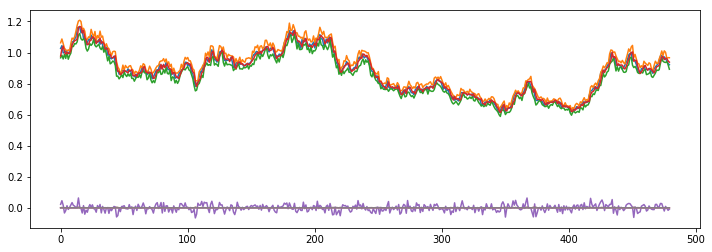

In [44]:
sim_j = sim_dataset[2]
print(sim_j['features'].shape, sim_j['targets'].shape)
plt.plot(sim_j['features']);

In [45]:
composed = transforms.Compose([ToArray(), RandomCrop(480), StartAt(100), ToTensor()])

sim_dataset = SimulatedPricesDataset(4, lambda: sim_path(N=500),
                                     min_icagr=0.3, Ch=True,
                                     transform=composed)

In [46]:
sim_j = sim_dataset[2]
print(sim_j['features'].size(), sim_j['targets'].size())

torch.Size([480, 8]) torch.Size([480, 3])


In [47]:
sim_j['features'][:6, :4]

tensor([[ 100.0000,  103.6061,   99.1658,  100.3224],
        [ 101.9931,  106.1053,   95.7740,  100.0154],
        [ 103.1073,  106.4851,   98.2867,  101.8882],
        [ 101.3634,  105.5466,   97.9931,  103.4001],
        [ 102.8312,  104.7468,   99.4689,  101.1747],
        [  98.0736,  105.6198,   95.2320,  102.0531]], dtype=torch.float64)

## Iterating through the dataset

In [51]:
sim_dataset = SimulatedPricesDataset(1000, lambda: sim_path(N=500),
                                     min_icagr=0.3,
                                     Ch=True, tech_windows=[5, 20, 60, 120],
                                     transform=transforms.Compose([
                                         ToArray(),
                                         RandomCrop(480),
                                         ToTensor()
                                     ]))

In [52]:
sim_loader = DataLoader(sim_dataset, batch_size=60, shuffle=False, num_workers=2)


for i_batch, sample_batched in enumerate(sim_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

//anaconda/envs/trend/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
//anaconda/envs/trend/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0 torch.Size([60, 480, 32]) torch.Size([60, 480, 3])
1 torch.Size([60, 480, 32]) torch.Size([60, 480, 3])
2 torch.Size([60, 480, 32]) torch.Size([60, 480, 3])
3 torch.Size([60, 480, 32]) torch.Size([60, 480, 3])
4 torch.Size([60, 480, 32]) torch.Size([60, 480, 3])
5 torch.Size([60, 480, 32]) torch.Size([60, 480, 3])


# Sharadar prices

In [53]:
class SharadarPricesDataset(Dataset):
    """Sharadar Prices Dataset"""
    def __init__(self, root_dir, min_length,
                 features=None,
                 targets=['Trend', 'Max_Drawdown', 'ATR'],
                 sd=20, min_icagr=None, 
                 transform=None):
        """
        Args:
            tickers (list of str): list of tickers.
            root_dir (str): directory with data frames: Date | OHLC.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.min_length = min_length
        self.targets = targets
        self.features = features
        self.sd = sd
        self.min_icagr = min_icagr
        self.transform = transform
        
        # Only series longer than min_length
        tickers = os.listdir(root_dir)
        lengths = [len(pd.read_feather(os.path.join(root_dir, f)))
                   for f in tickers]
        tickers_df = DataFrame(data={'ticker': tickers, 'length': lengths})
        self.fnames = list(
            tickers_df.query('length > ' + str(self.min_length)).ticker.values
        )
    
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        
        f_name = os.path.join(self.root_dir,
                              self.fnames[idx])
        
        df = pd.read_feather(f_name).set_index('Date')
        
        targets_df = find_trends(df, sd=self.sd)
        if self.min_icagr:
            targets_df = clean_trends(targets_df, min_icagr=self.min_icagr)
        if self.targets:
            targets_df = targets_df[self.targets]
        
        if self.features:
            df = df[self.features]
        
        sample = {'targets': targets_df, 'features': df}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [54]:
sh_train = 'input/Quandl/Sharadar/train/'

sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3)
print(len(sh_dataset), 'series.')

7059 series.


In [55]:
sh_j = sh_dataset[200]

In [56]:
sh_j['features']

,Open,High,Low,Close,Volume,Ch,Ch2,Ch3,Ch4,SMA_5,...,kurt_SMA_60,kurt_SMA_120,Support_5,Support_20,Support_60,Support_120,Resistance_5,Resistance_20,Resistance_60,Resistance_120
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-19,25.000,25.50,23.333,23.333,1110.0,0.000000,0.000000,0.000000,0.000000e+00,23.3330,...,-1.000000,-1.000000,23.333,23.333,23.333,23.333,25.50,25.50,25.50,25.50
2012-04-20,23.667,25.50,23.667,24.000,1290.0,0.028185,0.000794,0.000022,6.310768e-07,23.6665,...,-1.000000,-1.000000,23.333,23.333,23.333,23.333,25.50,25.50,25.50,25.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-06,2.640,2.65,2.555,2.580,75763.0,-0.011561,0.000134,-0.000002,1.786302e-08,2.4980,...,1.390211,3.309949,2.318,2.150,1.790,1.663,2.65,2.75,3.06,3.06
2018-07-09,2.640,2.75,2.600,2.700,89015.0,0.045462,0.002067,0.000094,4.271776e-06,2.5620,...,1.253401,3.175254,2.334,2.150,1.790,1.663,2.75,2.75,3.06,3.06


In [57]:
sh_j['targets']

,Trend,Max_Drawdown,ATR
Date,,,
2012-04-19,-1.0,0.661612,0.143009
2012-04-20,-1.0,NaN,NaN
...,...,...,...
2018-07-06,1.0,NaN,NaN
2018-07-09,1.0,NaN,NaN


## Transforms

In [ ]:
# sh_train = 'input/Quandl/Sharadar/train/'
# sh_dataset = SharadarPricesDataset(sh_train, min_length=600, min_icagr=0.3,
#                                    transform=transforms.Compose([
#                                        ToArray(),
#                                        RandomCrop(500),
#                                        StartAt(1),
#                                        ToTensor(),
#                                      ])
#                                    )

In [58]:
composed = transforms.Compose([
    ToArray(),
    RandomCrop(500),
    StartAt(1),
    ToTensor()
])

sh_dataset.transform = composed
print(len(sh_dataset), 'series.')

7059 series.


In [63]:
sh_j = sh_dataset[2]
print(sh_j['features'].size(), sh_j['targets'].size())

torch.Size([500, 33]) torch.Size([500, 3])


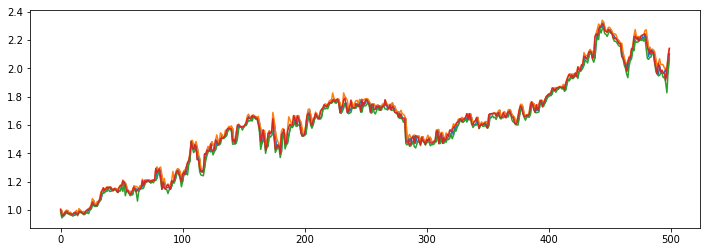

In [65]:
plt.plot(sh_j['features'][:, :4].numpy());

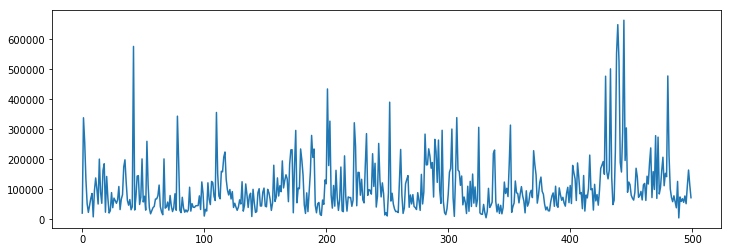

In [68]:
plt.plot(sh_j['features'][:, 4].numpy());

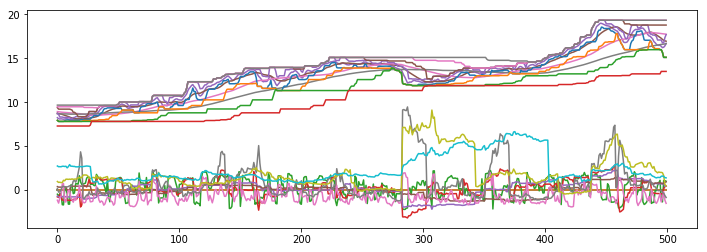

In [66]:
plt.plot(sh_j['features'][:, 5:].numpy());

## DataLoader

In [69]:
sh_loader = DataLoader(sh_dataset, batch_size=6)

for i_batch, sample_batched in enumerate(sh_loader):
    print(i_batch, sample_batched['features'].size(),
          sample_batched['targets'].size())
    
    if i_batch == 5:
        break

0 torch.Size([6, 500, 33]) torch.Size([6, 500, 3])
1 torch.Size([6, 500, 33]) torch.Size([6, 500, 3])
2 torch.Size([6, 500, 33]) torch.Size([6, 500, 3])
3 torch.Size([6, 500, 33]) torch.Size([6, 500, 3])
4 torch.Size([6, 500, 33]) torch.Size([6, 500, 3])
5 torch.Size([6, 500, 33]) torch.Size([6, 500, 3])


# End

In [185]:
df = pd.read_feather('input/Quandl/Sharadar/train/NIOBF.feather').set_index('Date')
df = find_trends(df)

/Users/juanpabloacosta/GitHub/trend-following/utils.py:403: RuntimeWarning: invalid value encountered in log
  icagr = np.log(ratio) * (364.25 / (pos_b.index[-1] - pos_b.index[0]).components.days)


In [192]:
df

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,n_Trend,Max_Drawdown,ATR,max_TR,min_TR,Ratio,ICAGR,Bliss,Trend_Start,Trend_End
Date,,,,,,,,,,,,,,,,,,,,
2009-12-23,0.310,0.310,0.310,0.310,5000.0,0.0,0.310,2017-11-01,0.409974,1.0,1.0,0.285714,0.069349,0.3125,0.0,1.290323,0.95716,3.350059,2009-12-23,2010-03-30
2009-12-24,0.330,0.330,0.330,0.330,1000.0,0.0,0.330,2017-11-01,0.410068,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-23,2010-03-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-03,0.451,0.461,0.450,0.458,38000.0,0.0,0.458,2018-07-05,0.475898,1.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-10,2018-07-05
2018-07-05,0.438,0.460,0.436,0.436,95600.0,0.0,0.436,2018-07-06,0.475906,1.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-05-10,2018-07-05


In [193]:
(df.Trend_End - df.Trend_Start).min()

Timedelta('31 days 00:00:00')

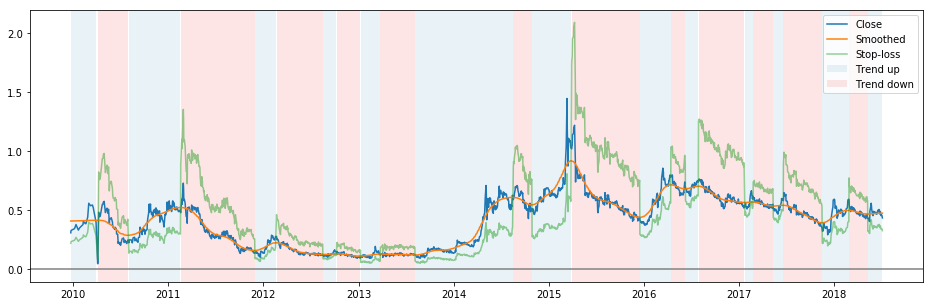

In [194]:
plot_trends(df)

In [198]:
df.Ratio.dropna().sort_values()

Date
2010-04-05   -3.081633
2013-03-26    1.000000
                ...   
2010-08-03    2.168889
2013-08-06    4.984127
Name: Ratio, Length: 25, dtype: float64

# TO DO:

Check why the ratio is < 0.